# Model

## Importing dependencies

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')


## DATA PREPROCESSING

In [11]:
def load_data(filepath):
    print("Loading dataset...")
    df = pd.read_csv(filepath)

    # Currency Conversion (1 USD = 87 INR)
    EXCHANGE_RATE = 87.0
    df['price_inr'] = df['price_usd'] * EXCHANGE_RATE

    # Encode Sentiment (Positive=1, Others=0)
    df['is_positive'] = df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

    # Parse Date
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['month_year'] = df['review_date'].dt.to_period('M')

    return df


## TRAINING

In [12]:
def train_success_classifier(df):
    # Aggregate by Brand and Model
    phone_stats = df.groupby(['brand', 'model']).agg({
        'price_inr': 'mean',
        'battery_life_rating': 'mean',
        'camera_rating': 'mean',
        'performance_rating': 'mean',
        'design_rating': 'mean',
        'display_rating': 'mean',
        'is_positive': 'mean',  
        'review_id': 'count'    
    }).reset_index()

    phone_stats.rename(columns={'is_positive': 'sentiment_score', 'review_id': 'popularity'}, inplace=True)

    # Encode Brand
    le_brand = LabelEncoder()
    phone_stats['brand_encoded'] = le_brand.fit_transform(phone_stats['brand'])

    # --- HONEST TRAINING (NO LEAKAGE) ---
    # Split Train/Test BEFORE calculating thresholds
    train_stats, test_stats = train_test_split(phone_stats, test_size=0.2, random_state=42)
    
    # Calculate thresholds ONLY on Training Data
    sent_threshold = train_stats['sentiment_score'].quantile(0.75)
    pop_threshold = train_stats['popularity'].quantile(0.50)

    # Define labeling logic
    def get_label(row):
        return 1 if (row['sentiment_score'] > sent_threshold) and (row['popularity'] > pop_threshold) else 0

    # Apply labels
    train_stats = train_stats.copy()
    test_stats = test_stats.copy()
    train_stats['is_successful'] = train_stats.apply(get_label, axis=1)
    test_stats['is_successful'] = test_stats.apply(get_label, axis=1)

    # Features
    feature_cols = ['brand_encoded', 'price_inr', 'battery_life_rating', 'camera_rating',
                    'performance_rating', 'design_rating', 'display_rating']

    # Train Model
    model = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
    model.fit(train_stats[feature_cols], train_stats['is_successful'])

    # Validate
    y_pred = model.predict(test_stats[feature_cols])
    print(f"Model Validation Accuracy: {accuracy_score(test_stats['is_successful'], y_pred):.2%}")

    # Retrain on Full Data for Production use
    full_sent_thresh = phone_stats['sentiment_score'].quantile(0.75)
    full_pop_thresh = phone_stats['popularity'].quantile(0.50)
    phone_stats['is_successful'] = ((phone_stats['sentiment_score'] > full_sent_thresh) & 
                                    (phone_stats['popularity'] > full_pop_thresh)).astype(int)
    
    model.fit(phone_stats[feature_cols], phone_stats['is_successful'])

    return model, phone_stats, le_brand

## Building Recommendation System

In [16]:
def build_recommender_system(phone_stats):
    features = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating',
                'design_rating', 'display_rating']
    X = phone_stats[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # KNN with MORE neighbors to handle replacements better
    knn = NearestNeighbors(n_neighbors=20, metric='euclidean')
    knn.fit(X_scaled)

    return knn, scaler, phone_stats


## Recommendation function

In [17]:
def get_recommendations(user_age, user_country, max_price, raw_df, phone_stats, model, le_brand, target_total_volume, unavailable_models=[], knn=None, scaler=None):
    print(f"\n--- 🔍 Analysis for Age {user_age}, Country {user_country}, Max Price ₹{max_price:.0f} ---")

    # 1. Filter Candidates by Price
    candidates = phone_stats[phone_stats['price_inr'] <= max_price].copy()

    if candidates.empty:
        print(" No phones found within price range.")
        return None, None

    # 2. Calculate Global Quality (Model Prediction)
    feature_cols = ['brand_encoded', 'price_inr', 'battery_life_rating', 'camera_rating',
                    'performance_rating', 'design_rating', 'display_rating']
    
    X_pred = candidates[feature_cols]
    candidates['global_quality'] = model.predict_proba(X_pred)[:, 1]

    # 3. Calculate Local Popularity (Market Share)
    age_min, age_max = user_age - 3, user_age + 3
    local_reviews = raw_df[(raw_df['country'] == user_country) &
                           (raw_df['age'] >= age_min) &
                           (raw_df['age'] <= age_max)]

    if local_reviews.empty:
        print("⚠️ No local data for this demographic. Popularity set to 0.")
        candidates['local_popularity'] = 0.0
        total_local = 1 
    else:
        local_counts = local_reviews['model'].value_counts().reset_index()
        local_counts.columns = ['model', 'local_count']
        total_local = len(local_reviews)
        local_counts['local_popularity'] = local_counts['local_count'] / total_local

        candidates = candidates.merge(local_counts, on='model', how='left')
        candidates['local_popularity'] = candidates['local_popularity'].fillna(0)
        candidates['local_count'] = candidates['local_count'].fillna(0)

    # ---------------------------------------------------------
    # 🆕 Two-Step Harmonic Mean Score
    # ---------------------------------------------------------
    
    # A. Normalize Popularity (0 to 1)
    pop_min = candidates['local_popularity'].min()
    pop_max = candidates['local_popularity'].max()
    candidates['sales_norm'] = (candidates['local_popularity'] - pop_min) / (pop_max - pop_min + 1e-9)

    # B. Step 1: Weighted Score
    candidates['balanced_score'] = (0.7 * candidates['global_quality']) + (0.3 * candidates['sales_norm'])

    # C. Step 2: Harmonic Mean
    candidates['final_score'] = 2 * (candidates['balanced_score'] * candidates['sales_norm']) / (candidates['balanced_score'] + candidates['sales_norm'] + 1e-9)

    # Add Forecasts
    candidates['next_month_forecast'] = candidates['model'].apply(lambda x: forecast_sales(x, raw_df)[0])

    # Top 5 Selection
    top_phones = candidates.sort_values(by='final_score', ascending=False).head(5)

    # 4. Handle Unavailable Models (Replacement Logic)
    replaced_models = []
    top_phones = top_phones.reset_index(drop=True)
    
    knn_features = ['price_inr', 'battery_life_rating', 'camera_rating', 'performance_rating',
                    'design_rating', 'display_rating']
    
    i = 0
    while i < len(top_phones):
        model_name = top_phones.iloc[i]['model']
        
        # Check availability (Case Insensitive)
        is_unavailable = False
        for u_model in unavailable_models:
            if model_name.lower() == u_model.lower():
                is_unavailable = True
                break
        
        if is_unavailable:
            target_row = top_phones.iloc[i]
            target_vector = target_row[knn_features].values.reshape(1, -1)
            target_scaled = scaler.transform(target_vector)
            
            distances, indices = knn.kneighbors(target_scaled)
            found = False
            
            for j in indices[0]:
                alt_row = phone_stats.iloc[j]
                alt_model = alt_row['model']
                
                alt_unavailable = any(alt_model.lower() == u.lower() for u in unavailable_models)
                
                if (not alt_unavailable) and (alt_model not in top_phones['model'].tolist()) and (alt_row['price_inr'] <= max_price):
                    
                    # --- RE-CALCULATE SCORE FOR REPLACEMENT ---
                    
                    # 1. Global Quality
                    alt_brand_encoded = le_brand.transform([alt_row['brand']])[0]
                    alt_pred = [[alt_brand_encoded] + alt_row[knn_features].tolist()]
                    alt_pred_df = pd.DataFrame(alt_pred, columns=feature_cols)
                    alt_global = model.predict_proba(alt_pred_df)[:,1][0]

                    # 2. Local Popularity
                    alt_local_pop = 0
                    alt_local_count_val = 0
                    if not local_reviews.empty:
                        match = local_counts[local_counts['model'] == alt_model]
                        if not match.empty:
                            alt_local_count_val = match['local_count'].values[0]
                            alt_local_pop = alt_local_count_val / total_local

                    # 3. New Formula for Alternative (FIXED)
                    # Clip sales_norm to 0-1 range to prevent math explosion
                    raw_sales_norm = (alt_local_pop - pop_min) / (pop_max - pop_min + 1e-9)
                    alt_sales_norm = max(0.0, min(1.0, raw_sales_norm))
                    
                    alt_balanced = 0.7 * alt_global + 0.3 * alt_sales_norm
                    alt_final = 2 * (alt_balanced * alt_sales_norm) / (alt_balanced + alt_sales_norm + 1e-9)

                    alt_forecast, _ = forecast_sales(alt_model, raw_df)

                    # --- EXPLICIT ASSIGNMENT (THE BUG FIX) ---
                    # Instead of replacing the whole row (which caused the swap error),
                    # we update columns one by one.
                    idx = top_phones.index[i]
                    
                    top_phones.at[idx, 'model'] = alt_model
                    top_phones.at[idx, 'brand'] = alt_row['brand']
                    top_phones.at[idx, 'price_inr'] = alt_row['price_inr']
                    top_phones.at[idx, 'global_quality'] = alt_global
                    top_phones.at[idx, 'local_popularity'] = alt_local_pop
                    top_phones.at[idx, 'local_count'] = alt_local_count_val
                    
                    top_phones.at[idx, 'sales_norm'] = alt_sales_norm
                    top_phones.at[idx, 'balanced_score'] = alt_balanced
                    top_phones.at[idx, 'final_score'] = alt_final
                    top_phones.at[idx, 'next_month_forecast'] = alt_forecast

                    replaced_models.append((model_name, alt_model))
                    found = True
                    break
            
            if not found:
                print(f"No suitable alternative found for {model_name}. Removing it.")
                top_phones = top_phones.drop(top_phones.index[i])
                continue
        i += 1

    if len(replaced_models) > 0:
        print("Replaced models:")
        for old, new in replaced_models:
            print(f"{old} -> {new}")
        # Re-sort to put the replacement in its correct place (likely lower down)
        top_phones = top_phones.sort_values(by='final_score', ascending=False).reset_index(drop=True)

    # 5. Calculate Quantities
    forecasts = top_phones['next_month_forecast'].values
    sum_f = sum(forecasts)
    if sum_f == 0:
        proportions = [1.0 / len(forecasts)] * len(forecasts)
    else:
        proportions = [f / sum_f for f in forecasts]

    top_phones['proportion'] = proportions
    top_phones['suggested_quantity'] = np.round(np.array(proportions) * target_total_volume).astype(int)

    # Display Results
    print("\n🏆 Top Recommended Phones to Stock (Harmonic Score):")
    display_cols = ['brand', 'model', 'price_inr', 'global_quality', 'sales_norm', 'final_score', 'suggested_quantity']
    print(top_phones[display_cols])

    estimated_revenue = sum(top_phones['suggested_quantity'] * top_phones['price_inr'])
    print(f"\nEstimated Revenue: ₹{estimated_revenue:.0f}")

    return top_phones, candidates


## FORECASTING(Alternative model predictor)

In [18]:
def forecast_sales(model_name, raw_df):
    model_data = raw_df[raw_df['model'] == model_name].copy()

    if model_data.empty:
        return 0, None

    monthly_sales = model_data.groupby('month_year').size().reset_index(name='sales')
    monthly_sales['month_index'] = np.arange(len(monthly_sales))

    if len(monthly_sales) < 2:
        return monthly_sales['sales'].mean(), monthly_sales

    X = monthly_sales[['month_index']]
    y = monthly_sales['sales']

    trend_model = LinearRegression()
    trend_model.fit(X, y)

    next_month_index = len(monthly_sales)
    next_month_sales = trend_model.predict([[next_month_index]])[0]

    return max(0, next_month_sales), monthly_sales

## Testing

Loading dataset...
Model Validation Accuracy: 80.00%

      MOBILE STOCKING RECOMMENDER


Enter Target Customer Age (e.g., 25):  30


Available Countries: Australia, Brazil, Canada, Germany, India, UAE, UK, USA


Enter Target Country:  USA
Enter Maximum Price per Phone (INR):  70000
Enter Target Total Sales Volume (units):  250



🔄 Generating recommendations (Excluded: 0 models)...

--- 🔍 Analysis for Age 30, Country USA, Max Price ₹70000 ---

🏆 Top Recommended Phones to Stock (Harmonic Score):
      brand            model     price_inr  global_quality  sales_norm  \
0    Realme    Realme 12 Pro  34257.169960        0.289638    1.000000   
1    Realme  Realme Narzo 70  34163.306088        0.290144    0.772727   
2    Xiaomi    Redmi Note 13  39132.733142        0.264089    0.590909   
3    Xiaomi        Mi 13 Pro  39053.143558        0.264494    0.303030   
4  Motorola          Edge 50  44264.380497        0.238810    0.287879   

   final_score  suggested_quantity  
0     0.669104                  62  
1     0.556577                  63  
2     0.449064                  42  
3     0.288914                  43  
4     0.269615                  41  

Estimated Revenue: ₹9413932

--------------------------------------------------


Are any of the above models unavailable? (yes/no):  no


✅ Selection Finalized.

📈 SALES TREND OF BEST MODEL → Realme 12 Pro



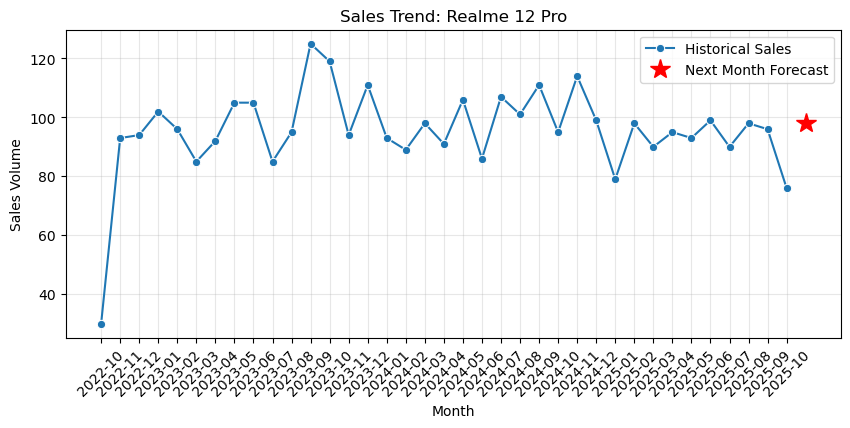

In [22]:
if __name__ == "__main__":
    filepath = "Mobile Reviews Sentiment.csv"
    
    if not os.path.exists(filepath):
        print(f"❌ Error: File '{filepath}' not found.")
    else:
        raw_df = load_data(filepath)
        success_model, phone_stats, le_brand = train_success_classifier(raw_df)
        knn, scaler, phone_stats = build_recommender_system(phone_stats)

        try:
            print("\n" + "="*40)
            print("      MOBILE STOCKING RECOMMENDER")
            print("="*40)
            
            # 1. Get Base Inputs
            age = int(input("Enter Target Customer Age (e.g., 25): "))

            available_countries = sorted(raw_df['country'].unique())
            print(f"Available Countries: {', '.join(available_countries)}")
            country = input("Enter Target Country: ").strip()
            if country not in available_countries:
                print("⚠️ Invalid country. Defaulting to 'India'.")
                country = "India"

            max_price = float(input("Enter Maximum Price per Phone (INR): "))
            target_total_volume = float(input("Enter Target Total Sales Volume (units): "))

            unavailable_models = []
            
            # 2. Interactive Loop
            while True:
                print(f"\n🔄 Generating recommendations (Excluded: {len(unavailable_models)} models)...")
                
                top_5, all_candidates = get_recommendations(
                    age, country, max_price, raw_df, phone_stats, 
                    success_model, le_brand, target_total_volume, 
                    unavailable_models, knn, scaler
                )

                if top_5 is None or top_5.empty:
                    print("❌ No recommendations available.")
                    break

                # 3. Ask for changes
                print("\n" + "-"*50)
                user_response = input("Are any of the above models unavailable? (yes/no): ").lower().strip()

                if user_response in ['yes', 'y']:
                    user_input = input("Enter the Model Name to remove (e.g., Poco X6): ").strip()
                    
                    found_match = False
                    actual_name_in_db = ""
                    current_models = top_5['model'].values
                    
                    for model_name in current_models:
                        if model_name.lower() == user_input.lower():
                            actual_name_in_db = model_name
                            found_match = True
                            break
                    
                    if found_match:
                        if actual_name_in_db not in unavailable_models:
                            unavailable_models.append(actual_name_in_db)
                            print(f"🚫 Success: '{actual_name_in_db}' has been removed. Recalculating...")
                        else:
                            print(f"⚠️ '{actual_name_in_db}' is already in the unavailable list.")
                    else:
                        print(f"❌ Error: Could not find '{user_input}' in the top 5 list.")
                        print(f"   (Did you mean one of these: {', '.join(current_models)}?)")
                        
                else:
                    print("✅ Selection Finalized.")
                    break 
            
            # 4. Final Visualizations
            if top_5 is not None and not top_5.empty:
                # Sales Trend
                best_phone = top_5.iloc[0]['model']
                print(f"\n📈 SALES TREND OF BEST MODEL → {best_phone}\n")

                _, history = forecast_sales(best_phone, raw_df)
                if history is not None:
                    plt.figure(figsize=(10, 4))
                    history_plot = history.copy()
                    history_plot['month_str'] = history_plot['month_year'].astype(str)
                    
                    sns.lineplot(data=history_plot, x='month_str', y='sales', marker='o', label='Historical Sales')
                    
                    next_val = top_5.iloc[0]['next_month_forecast']
                    plt.plot(len(history), next_val, 'r*', markersize=15, label='Next Month Forecast')
                    
                    plt.title(f'Sales Trend: {best_phone}')
                    plt.xlabel('Month')
                    plt.ylabel('Sales Volume')
                    plt.xticks(rotation=45)
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()

        except ValueError:
            print("❌ Input Error: Please ensure you enter valid numbers.")
        except Exception as e:
            import traceback
            traceback.print_exc()